## XCDM v ABC + $H_0^{\rm P18}$

Importing pyabc and standard python scientific packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.constants import c
from scipy.integrate import quad

import os
import tempfile

import pyabc
from pyabc import Distribution, RV
from pyabc import ABCSMC, History
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.visualization import plot_kde_1d

plt.rcParams['text.usetex'] = True

In this work, we consider compiled data sets from supernovae, cosmic chronometers, and baryon acoustic oscillations. Below, we import the CC and BAO data sets, providing measurements of the cosmic expansion rate with error bars.

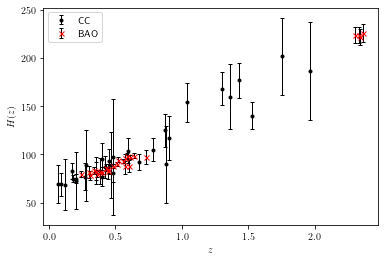

In [2]:
# load CC and BAO expansion rate data
cc_loc = 'https://raw.githubusercontent.com/reggiebernardo/\
datasets/main/Hdz_2020_CConly.txt'
cc_data = np.loadtxt(cc_loc)

z_cc = cc_data[:, 0]
Hz_cc = cc_data[:, 1]
sigHz_cc = cc_data[:, 2]

bao_loc = 'https://raw.githubusercontent.com/reggiebernardo/\
datasets/main/Hdz_2020_BAOonly.txt'
bao_data = np.loadtxt(bao_loc)

z_bao = bao_data[:, 0]
Hz_bao = bao_data[:, 1]
sigHz_bao = bao_data[:, 2]

fig, ax = plt.subplots()
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, fmt = 'ko', ecolor = 'k', \
            markersize = 3, elinewidth = 1, capsize = 2, label = 'CC')
ax.errorbar(z_bao, Hz_bao, yerr = sigHz_bao, fmt = 'rx', ecolor = 'k', \
            markersize = 5, elinewidth = 1, capsize = 2, label = 'BAO')

ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
ax.legend(loc = 'upper left', prop = {'size': 9.5})
plt.show()

Then, here is the largest supernovae compilation to date, referred to as the Pantheon+, by the Pantheon group.

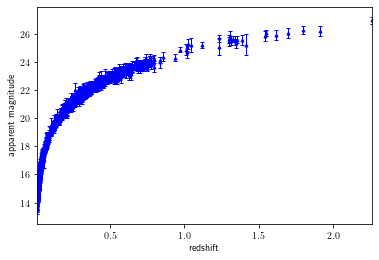

In [3]:
loc_lcparam = 'https://github.com/PantheonPlusSH0ES/DataRelease/raw/main/\
Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat'

# pantheon plus systematics

lcparam = np.loadtxt(loc_lcparam, skiprows = 1, usecols = (2, 8, 9, 10, 11))

# setup pantheon samples
z_pp = lcparam[:, 0][111:]
mz_pp = lcparam[:, 1][111:]
sigmz_pp = lcparam[:, 2][111:]

mMz_pp = lcparam[:, 3][111:]
sigmMz_pp = lcparam[:, 4][111:]

# apparent magnitudes
plt.errorbar(z_pp, mz_pp, yerr = sigmz_pp,
             fmt = 'b^', markersize = 3,
             ecolor = 'blue', elinewidth = 1, capsize = 2)
plt.xlim(min(z_pp), max(z_pp))
plt.xlabel('redshift')
plt.ylabel('apparent magnitude')
plt.show()

This comes with a full covariance matrix, imported in the next line.

In [4]:
# load the pantheon+ covariance matrix

loc_lcparam_sys = 'https://raw.githubusercontent.com/PantheonPlusSH0ES/\
DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STAT%2BSYS.cov'
lcparam_sys = np.loadtxt(loc_lcparam_sys, skiprows = 1)

# pantheon plus systematics
cov = lcparam_sys.reshape(1701, 1701)
cov_tot = cov[111:, 111:]

# inverse to be used for calculations
cov_inv = np.linalg.inv(cov_tot)

We also consider $H_0$ priors, reflective of the current state of the Hubble tension, and matter density priors.

In [5]:
# H0 values reflecting the Hubble tension
H0_priors = {'P18': {'ave': 67.4, 'std': 0.5}, \
             'R22': {'ave': 73.30, 'std': 1.04}}

om0_priors = {'P18': {'ave': 0.1430, 'std':0.0011}} # Planck data

The redshift distribution of these data sets are shown below.

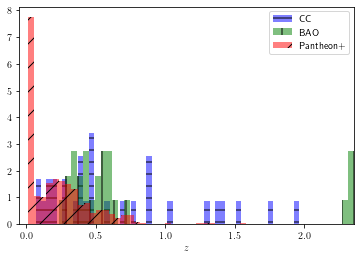

In [6]:
z_cc_bao_pp = np.concatenate((z_cc, z_bao, z_pp))

fig, ax = plt.subplots()
ax.hist(z_cc, bins = 50, color = 'b', alpha = 0.5, \
        density = True, label = r'CC', hatch = '-')
ax.hist(z_bao, bins = 50, color = 'g', alpha = 0.5, \
        density = True, label = r'BAO', hatch = '|')
ax.hist(z_pp, bins = 50, color = 'r', alpha = 0.5, \
        density = True, label = 'Pantheon+', hatch = '/')
ax.set_xlabel('$z$')
ax.legend(loc = 'upper right', prop = {'size': 9.5})
ax.set_ylabel('')
ax.set_xlim(-0.05, max(z_cc_bao_pp))
plt.show()

### XCDM

We setup a code for quadratic XCDM (or $X_2$CDM) predictions of the expansion rate and the supernovae brightness.

In [7]:
def Xz_qd(z, zm, f1, f2):
    '''parameterized DE density in XCDM (quadratic)'''
    return 1 + (z*(4*f1 - f2 - 3)/zm) - (2*(z**2)*(2*f1 - f2 - 1)/(zm**2))

def Xpz_qd(z, zm, f1, f2):
    '''first derivative of X(z)'''
    return -((3 - 4*f1 + f2)/zm) + (4*(1 - 2*f1 + f2)*z/(zm**2))

def wz_qd(z, zm, f1, f2):
    '''DE EoS in XCDM'''
    x1 = f1
    x2 = f2
    return (z + 1)*(-z*(8*x1 - 4*x2 - 4)/zm**2 + (4*x1 - x2 - 3)/zm) \
           /(-3*z**2*(4*x1 - 2*x2 - 2)/zm**2 + 3*z*(4*x1 - x2 - 3)/zm + 3) - 1

def Ez_qd(z, om0, f1, f2, zm):
    '''normalized Hubble function for XCDM'''
    z1 = 1 + z
    Xm = om0*(z1**3)
    Xz = Xz_qd(z, zm, f1, f2)
    Ol = (1 - om0)*Xz
    return np.sqrt(Xm + Ol)

def f(z, zm, om0, f1, f2):
    return 1.0/Ez_qd(z, om0, f1, f2, zm)

def rr(z, zm, om0, f1, f2):
    return quad(lambda x: f(x, zm, om0, f1, f2), 0, z,)[0]

def dlh(z, om0, f1, f2, zm):
    return rr(z, zm, om0, f1, f2)*(1 + z)

def mMz_qd(z, H0, om0, f1, f2, zm):
    '''XCDM distance modulus'''
    h = H0/100
    return 5*np.log10((c/h)*dlh(z, om0, f1, f2, zm))

def mz_qd(z, H0, om0, f1, f2, zm, M):
    '''XCDM apparent magnitude'''
    return mMz_qd(z, H0, om0, f1, f2, zm) + M

We test their $\Lambda$CDM predictions with the expansion rate and supernovae observations.

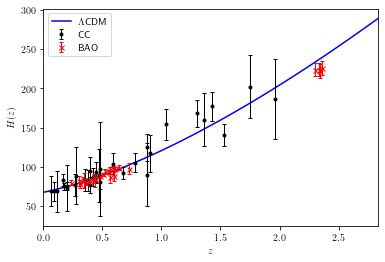

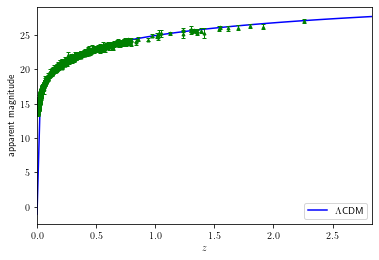

In [8]:
# LambdaCDM + Planck
ztest = np.linspace(1e-5, max(z_cc_bao_pp)*6/5, 100)
H0test = H0_priors['P18']['ave']
h2test = (H0test/100)**2
om0test = om0_priors['P18']['ave']/h2test
Hztest = H0test*Ez_qd(ztest, om0test, f1 = 1, f2 = 1, zm = max(z_cc_bao_pp))
mztest = [mz_qd(z, H0test, om0test, f1 = 1, f2 = 1, \
                zm = max(z_cc_bao_pp), M = -19.3) for z in ztest]

fig, ax = plt.subplots()
ax.plot(ztest, Hztest, 'b-', label = '$\Lambda$CDM')
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, fmt = 'ko', ecolor = 'k', \
            markersize = 3, elinewidth = 1, capsize = 2, label = 'CC')
ax.errorbar(z_bao, Hz_bao, yerr = sigHz_bao, fmt = 'rx', ecolor = 'red', \
            markersize = 5, elinewidth = 1, capsize = 2, label = 'BAO')

ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
ax.set_xlim(0, max(z_cc_bao_pp)*6/5)
ax.legend(loc = 'upper left', prop = {'size': 9.5})
plt.show()

# apparent magnitudes
fig, ax = plt.subplots()
ax.plot(ztest, mztest, 'b-', label = '$\Lambda$CDM')
ax.errorbar(z_pp, mz_pp, yerr = sigmz_pp, \
            fmt = 'g^', markersize = 3, \
            ecolor = 'green', elinewidth = 1, capsize = 2)
ax.set_xlabel('$z$')
ax.set_ylabel('apparent magnitude')
ax.set_xlim(0, max(z_cc_bao_pp)*6/5)
ax.legend(loc = 'lower right', prop = {'size': 9.5})
plt.show()

We also setup the cubic XCDM ($X_3$CDM) predictions.

In [9]:
def Xz_cb(z, zm, f1, f2, f3):
    '''returns the cubic parametrized DE density'''
    Xz = ((9*(-1 + 3*f1 - 3*f2 + f3)*(z**3)) - (9*(-2 + 5*f1 - 4*f2 + f3)*zm*(z**2)) 
          + ((-11 + 18*f1 - 9*f2 + 2*f3)*z*(zm**2)) + (2*zm**3))/(2*(zm**3))
    return Xz

def Xpz_cb(z, zm, f1, f2, f3):
    '''returns the statistic X'(z) for dynamical dark energy'''
    term_1 = (-11 + 18*f1 - 9*f2 + 2*f3)/(2*zm)
    term_2 = -9*(-2 + 5*f1 - 4*f2 + f3)*z/(zm**2)
    term_3 = 27*(-1 + 3*f1 - 3*f2 + f3)*(z**2)/(2*(zm**3))
    return term_1 + term_2 + term_3

def wz_cb(z, zm, f1, f2, f3):
    '''returns the DE EoS in cubic parametrized DE'''
    x1 = f1
    x2 = f2
    x3 = f3
    num = z**2*(81*x1 - 81*x2 + 27*x3 - 27.0)/zm**3 \
          - z*(90*x1 - 72*x2 + 18*x3 - 36.0)/zm**2 \
          + (18*x1 - 9*x2 + 2*x3 - 11.0)/zm
    den = z**3*(27*x1 - 27*x2 + 9*x3 - 9.0)/zm**3 \
          - z**2*(45*x1 - 36*x2 + 9*x3 - 18.0)/zm**2 \
          + z*(18*x1 - 9*x2 + 2*x3 - 11.0)/zm
    return -1 + ((1/6)*(1 + z)*num)/(1 + (den/2))

def Ez_cb(z, om0, f1, f2, f3, zm):
    '''returns the Hubble function in cubic parameterized DE method'''
    z1 = 1 + z
    Xm = om0*(z1**3)
    Xz = Xz_cb(z, zm, f1, f2, f3)
    Ol = (1 - om0)*Xz
    return np.sqrt(Xm + Ol)

def f_cb(z, om0, f1, f2, f3, zm):
    return 1.0/Ez_cb(z, om0, f1, f2, f3, zm)

def rr_cb(z, om0, f1, f2, f3, zm):
    return quad(lambda x: f_cb(x, om0, f1, f2, f3, zm), 0, z, )[0]

def dlh_cb(z, om0, f1, f2, f3, zm):
    return rr_cb(z, om0, f1, f2, f3, zm)*(1. + z)

def mMz_cb(z, H0, om0, f1, f2, f3, zm):
    '''X3CDM distance modulus'''
    h = H0/100
    return 5*np.log10((c/h)*dlh_cb(z, om0, f1, f2, f3, zm))

def mz_cb(z, H0, om0, f1, f2, f3, zm, M):
    '''X3CDM apparent magnitude'''
    return mMz_cb(z, H0, om0, f1, f2, f3, zm) + M

The $\Lambda$CDM limit is tested below.

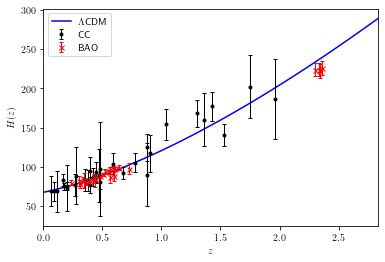

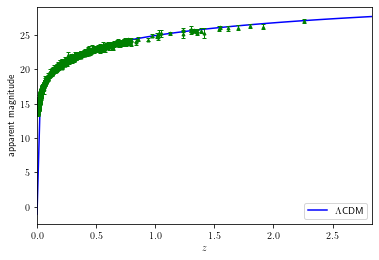

In [10]:
# LambdaCDM + Planck
ztest = np.linspace(1e-5, max(z_cc_bao_pp)*6/5, 100)
H0test = H0_priors['P18']['ave']
h2test = (H0test/100)**2
om0test = om0_priors['P18']['ave']/h2test
Hztest = H0test*Ez_cb(ztest, om0test, \
                      f1 = 1, f2 = 1, f3 = 1, zm = max(z_cc_bao_pp))
mztest = [mz_cb(z, H0test, om0test, f1 = 1, f2 = 1, f3 = 1, \
                zm = max(z_cc_bao_pp), M = -19.3) for z in ztest]

fig, ax = plt.subplots()
ax.plot(ztest, Hztest, 'b-', label = '$\Lambda$CDM')
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, fmt = 'ko', ecolor = 'k', \
            markersize = 3, elinewidth = 1, capsize = 2, label = 'CC')
ax.errorbar(z_bao, Hz_bao, yerr = sigHz_bao, fmt = 'rx', ecolor = 'red', \
            markersize = 5, elinewidth = 1, capsize = 2, label = 'BAO')

ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
ax.set_xlim(0, max(z_cc_bao_pp)*6/5)
ax.legend(loc = 'upper left', prop = {'size': 9.5})
plt.show()

# apparent magnitudes
fig, ax = plt.subplots()
ax.plot(ztest, mztest, 'b-', label = '$\Lambda$CDM')
ax.errorbar(z_pp, mz_pp, yerr = sigmz_pp, \
            fmt = 'g^', markersize = 3, \
            ecolor = 'green', elinewidth = 1, capsize = 2)
ax.set_xlabel('$z$')
ax.set_ylabel('apparent magnitude')
ax.set_xlim(0, max(z_cc_bao_pp)*6/5)
ax.legend(loc = 'lower right', prop = {'size': 9.5})
plt.show()

### ABC part

Here, we setup the ABC algorithm which will create a joint model space and also estimate the parameters while pitting the models against each other. We consider the $\Lambda$CDM and the XCDM models.

A $\Lambda$CDM class is setup below to start.

In [11]:
class LCDM:    
    __name__ = 'LambdaCDM'
        
    def __call__(self, par):
        # CC + BAO predictions
        Ez_cc = Ez_qd(z_cc, par['om0'], f1 = 1, f2 = 1, zm = max(z_cc_bao_pp))
        Ez_bao = Ez_qd(z_bao, par['om0'], f1 = 1, f2 = 1, zm = max(z_cc_bao_pp))

        # SNe prediction
        m_arr = np.array([mz_qd(z, par['H0'], par['om0'], f1 = 1, f2 = 1, \
                          zm = max(z_cc_bao_pp), M = -par['M']) for z in z_pp])

        return {"CC": par['H0']*Ez_cc, "BAO": par['H0']*Ez_bao, "SNe": m_arr}

# test this works for a fiducial H0 = 72, Om = 0.3, M = -19.3
oa = LCDM()
oa({'H0': 72, 'om0': 0.3, 'M': 19.3})

{'CC': array([ 74.39077143,  75.11876664,  76.24791161,  78.22805467,
         78.60153358,  79.44485772,  79.47443362,  82.54965319,
         83.00777548,  86.43699298,  87.85075336,  88.86095205,
         88.88153732,  90.14515113,  91.47174089,  92.56850744,
         93.02194185,  93.11517018,  99.57144674, 104.87629062,
        111.43380661, 117.8427974 , 118.16342029, 119.5655335 ,
        129.51355909, 150.16963208, 155.39885021, 161.07209618,
        169.74728154, 189.6631224 , 210.15854825]),
 'BAO': array([ 81.20333518,  83.93791992,  84.40989944,  85.85320577,
         86.34335643,  86.83799382,  87.84063737,  88.86095205,
         90.42414902,  90.95384718,  90.95384718,  93.11517018,
         94.78015296,  95.34339936,  97.63701226,  98.22045405,
         98.22045405,  99.39921922,  99.99449585, 100.59367083,
        102.41435499, 108.07953312, 243.96315787, 247.09547293,
        248.14328857, 250.24445786]),
 'SNe': array([13.84887992, 13.85103272, 13.85103272, ..., 26.317

We setup a different class for $X_2$CDM, with two more parameters to describe the varying dark energy.

In [12]:
class X2CDM:    
    __name__ = 'X2CDM'
        
    def __call__(self, par):
        # CC + BAO predictions
        h2 = (par['H0']/100)**2
        om0 = par['om0h2']/h2
        Ez_cc = Ez_qd(z_cc, om0, f1 = par['x1'], \
                      f2 = par['x2'], zm = max(z_cc_bao_pp))
        Ez_bao = Ez_qd(z_bao, om0, f1 = par['x1'], \
                       f2 = par['x2'], zm = max(z_cc_bao_pp))

        # SNe prediction
        m_arr = np.array([mz_qd(z, par['H0'], om0, \
                                f1 = par['x1'], f2 = par['x2'], \
                                zm = max(z_cc_bao_pp), M = -par['M']) \
                          for z in z_pp])

        return {"CC": par['H0']*Ez_cc, "BAO": par['H0']*Ez_bao, "SNe": m_arr}

# test this works for a fiducial H0 = 72, Om = 0.3, M = -19.3, x1 = 0.5, x2 = 1
ob = X2CDM()
ob({'H0': 72, 'om0h2': om0_priors['P18']['ave'], 'M': 19.3, 'x1': 0.5, 'x2': 1})

{'CC': array([ 72.73047458,  73.01019447,  73.48942775,  74.44752656,
         74.64330866,  75.10138789,  75.11784143,  76.95773602,
         77.25175352,  79.59035684,  80.61691167,  81.36991321,
         81.38541724,  82.3487465 ,  83.38336343,  84.25539098,
         84.62005846,  84.69532647,  90.11824917,  94.82254244,
        100.85911094, 106.93163994, 107.23900343, 108.58662773,
        118.28484418, 138.90724122, 144.1880794 , 149.93394886,
        158.74492134, 179.03772481, 199.95510888]),
 'BAO': array([ 76.1222277 ,  77.86286738,  78.17989309,  79.17638677,
         79.52355384,  79.87815042,  80.60945076,  81.36991321,
         82.56442399,  82.97674095,  82.97674095,  84.69532647,
         86.05551448,  86.5221836 ,  88.45370794,  88.95251409,
         88.95251409,  89.96883333,  90.48623113,  91.00971093,
         92.61606827,  97.74513709, 234.43097398, 237.62155934,
        238.68868598, 240.8283    ]),
 'SNe': array([13.85264119, 13.85479767, 13.85479767, ..., 26.481

Here, we also consider $X_3$CDM.

In [13]:
class X3CDM:    
    __name__ = 'X3CDM'
        
    def __call__(self, par):
        # CC + BAO predictions
        h2 = (par['H0']/100)**2
        om0 = par['om0h2']/h2
        Ez_cc = Ez_cb(z_cc, om0, f1 = par['x1'], \
                      f2 = par['x2'], f3 = par['x3'], zm = max(z_cc_bao_pp))
        Ez_bao = Ez_cb(z_bao, om0, f1 = par['x1'], \
                       f2 = par['x2'], f3 = par['x3'], zm = max(z_cc_bao_pp))

        # SNe prediction
        m_arr = np.array([mz_cb(z, par['H0'], om0, \
                                f1 = par['x1'], f2 = par['x2'], f3 = par['x3'], \
                                zm = max(z_cc_bao_pp), M = -par['M']) \
                          for z in z_pp])

        return {"CC": par['H0']*Ez_cc, "BAO": par['H0']*Ez_bao, "SNe": m_arr}

# test this works for a fiducial H0 = 72, Om = 0.3, M = -19.3, x1 = 0.5, x2 = 1
ob = X3CDM()
ob({'H0': 72, 'om0h2': om0_priors['P18']['ave'], 'M': 19.3, \
    'x1': 0.5, 'x2': 1, 'x3': 1})

{'CC': array([ 71.00170302,  70.86382182,  70.78093179,  70.97257318,
         71.05146011,  71.27443749,  71.28334075,  72.56270745,
         72.80684199,  74.98851371,  76.04228348,  76.84106586,
         76.85771052,  77.9055984 ,  79.05681181,  80.04378936,
         80.46033318,  80.54656148,  86.91023158,  92.53838817,
         99.75839042, 106.94717201, 107.30835231, 108.88861029,
        120.09254177, 142.92199834, 148.56327228, 154.61391158,
        163.72455891, 184.00298452, 203.99610126]),
 'BAO': array([ 71.92115565,  73.33952159,  73.62770479,  74.57733632,
         74.92157525,  75.27931842,  76.03446927,  76.84106586,
         78.14357456,  78.60155246,  78.60155246,  80.54656148,
         82.11787071,  82.66191263,  84.93375414,  85.52459264,
         85.52459264,  86.73230386,  87.34878243,  87.97341859,
         89.89439493,  96.03968876, 235.23866563, 238.03402318,
        238.96557533, 240.8283    ]),
 'SNe': array([13.85683239, 13.85899296, 13.85899296, ..., 26.512

Now, as required by ABC, we must input a distance function. For this, we setup the chi-squared, which is reasonable to account for the error bars in a real data.

In [14]:
# observation
obs = {"CC": Hz_cc, "BAO": Hz_bao, "SNe": mz_pp}
N_obs = sum([len(z_cc), len(z_bao), len(z_pp)]) # observation size

# distance function
def distance(x, y):
    chi2_cc = sum(((x['CC'] - y['CC'])**2)/sigHz_cc**2)
    chi2_bao = sum(((x['BAO'] - y['BAO'])**2)/sigHz_bao**2)
    xy = x['SNe'] - y['SNe']
    chi2_sn = xy.T @ cov_inv @ xy
    chi2_tot = chi2_cc + chi2_bao + chi2_sn
    return chi2_tot/N_obs

# distance of LCDM(H0 = 72, Om = 0.3, M = -19.3)
dtest = distance(LCDM()({"H0": 72, "om0": 0.3, "M": 19.3}), obs)
print('LCDM')
print('distance =', dtest)
print()

# distance of X2CDM(H0 = 72, Om = 0.3, x1 = 0.5, x2 = 1, M = -19.3)
dtest = distance(X2CDM()({"H0": 72, 'om0h2': om0_priors['P18']['ave'], \
                          "M": 19.3, 'x1': 0.5, 'x2': 1}), obs)
print('X2CDM')
print('distance =', dtest)
print()

# distance of X3CDM(H0 = 72, Om = 0.3, x1 = 0.5, x2 = 1, x3 = 1, M = -19.3)
dtest = distance(X3CDM()({"H0": 72, 'om0h2': om0_priors['P18']['ave'], \
                          "M": 19.3, 'x1': 0.5, 'x2': 1, 'x3': 1}), obs)
print('X3CDM')
print('distance =', dtest)
print()

LCDM
distance = 0.9262403987498263

X2CDM
distance = 1.1168657566975702

X3CDM
distance = 1.6657978398031374



We get on to the actual ABC part. Below, we setup the joint model space and the priors to be considered during the SMC.

In [15]:
# models
models = [LCDM(), X2CDM(), X3CDM()]

# LambdaCDM priors
H0_P18 = H0_priors['P18']['ave']
sigH0_P18 = H0_priors['P18']['std']
p1 = Distribution(H0 = RV("norm", H0_P18, sigH0_P18), \
                  om0 = RV("uniform", 0.20, 0.40), \
                  M = RV("uniform", 19.0, 19.6))

# X2CDM priors, uses Planck matter fraction prior
om0_P18 = om0_priors['P18']['ave']
sigom0_P18 = om0_priors['P18']['std']
p2 = Distribution(H0 = RV("norm", H0_P18, sigH0_P18), \
                  om0h2 = RV("norm", om0_P18, sigom0_P18), \
                  M = RV("uniform", 19.0, 19.6), \
                  x1 = RV("uniform", 0, 2), x2 = RV("uniform", -1, 2))
p3 = Distribution(H0 = RV("norm", H0_P18, sigH0_P18), \
                  om0h2 = RV("norm", om0_P18, sigom0_P18), \
                  M = RV("uniform", 19.0, 19.6), \
                  x1 = RV("uniform", 0, 2), x2 = RV("uniform", -1, 2), \
                  x3 = RV("uniform", -1, 2))

priors = [p1, p2, p3]

We then setup an adaptive population strategy to go with the algorithm, and put all these (models, priors, distance function, population) together.

In [ ]:
# adaptive population size
pop_size = AdaptivePopulationSize(300, mean_cv = 0.15)

abc = pyabc.ABCSMC(models, priors, distance, population_size = pop_size)

# store the results
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "X23CDMvABCwH0P18.db")

# # run next line if starting from nothing
history = abc.new(db_path, obs)

# # if there are previous runs to check: history checking

# to specify an id, good id = ...
# history = pyabc.History(db_path, _id = 2)

# defaults to latest/largest id in the database
# history = pyabc.History(db_path)
# print('id = ', history.id)
# print('n_pop =', history.n_populations)

A new run can be loaded as follows.

In [17]:
# # # run the ABC until either criterion is met
history = abc.run(minimum_epsilon = 0.5, max_nr_populations = 20)

A previous run can be loaded as follows...

Here is the model posterior per generation.

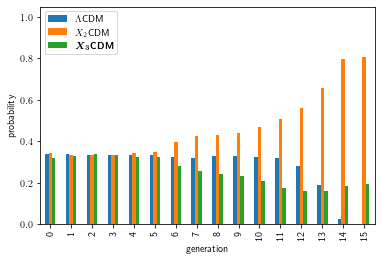

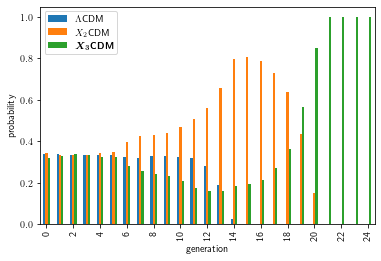

In [18]:
# set history
# history = history_continued # if loading previous run

ax = history.get_model_probabilities().plot.bar();
ax.set_ylabel("probability");
ax.set_xlabel("generation");
ax.legend(['$\Lambda$CDM', '$X_2$CDM', r'\textbf{{{\boldmath$X_3$}CDM}'],
          ncol = 1, loc = "upper left", prop = {'size': 9.5})
ax.set_xlim(-0.5, 16 - 0.5)
plt.show()

ax = history.get_model_probabilities().plot.bar();
ax.set_ylabel("probability");
ax.set_xlabel("generation");
ax.legend(['$\Lambda$CDM', '$X_2$CDM', r'\textbf{{{\boldmath$X_3$}CDM}'],
          ncol = 1, loc = "upper left", prop = {'size': 9.5})
ax.set_xlim(-0.5, 25 - 0.5)
ax.set_xticks(np.arange(0, 25, 2))
plt.show()

We obtain the parameters determined throughout and at the end of the models.

In [19]:
# convert (om0h2, H0) to om0
def Om0(H0v, sigH0v, om0h2v, sigom0h2v):
    # mean
    h2v = (H0v/100)**2
    om0v = om0h2v/h2v

    # uncertainty
    t1 = sigom0h2v/om0h2v
    t2 = -2*sigH0v/H0v
    sigom0v = om0v*(t1 + t2)
    return om0v, sigom0v

mods = ['LCDM', 'X2CDM', 'X3CDM']

last_pop = {}
n_gen = history.n_populations
for m in np.arange(0, len(models)):
    t = n_gen - 1
    df, w = history.get_distribution(m = m, t = t)
    while df.empty == True:
        t -= 1
        df, w = history.get_distribution(m = m, t = t)
    df_arr = df.to_numpy()
    if m == 0: # LCDM (3 parameters)
        H0_abc, sigH0_abc = np.mean(df_arr[:, 0]), np.std(df_arr[:, 0])
        M_abc, sigM_abc = np.mean(df_arr[:, 1]), np.std(df_arr[:, 1])
        om0_abc, sigom0_abc = np.mean(df_arr[:, 2]), np.std(df_arr[:, 2])
        print(mods[m])
        print('H0 = ', H0_abc, '+/-', sigH0_abc)
        print('om0 = ', om0_abc, '+/-', sigom0_abc)
        print('M = ', M_abc, '+/-', sigM_abc)
        print()
        last_pop[mods[m]] = {'df': df, 'w': w, \
                             'om0': om0_abc, 'sigom0': sigom0_abc, \
                             'H0': H0_abc, 'sigH0': sigH0_abc, \
                             'M': M_abc, 'sigM': sigM_abc}
    if m == 1: # X2CDM (5 parameters)
        H0_abc, sigH0_abc = np.mean(df_arr[:, 0]), np.std(df_arr[:, 0])
        M_abc, sigM_abc = np.mean(df_arr[:, 1]), np.std(df_arr[:, 1])
        om0h2_abc, sigom0h2_abc = np.mean(df_arr[:, 2]), np.std(df_arr[:, 2])
        om0_abc, sigom0_abc = Om0(H0_abc, sigH0_abc, om0h2_abc, sigom0h2_abc)
        x1_abc, sigx1_abc = np.mean(df_arr[:, 3]), np.std(df_arr[:, 3])
        x2_abc, sigx2_abc = np.mean(df_arr[:, 4]), np.std(df_arr[:, 4])
        print(mods[m])
        print('H0 = ', H0_abc, '+/-', sigH0_abc)
        print('om0h2 = ', om0h2_abc, '+/-', sigom0h2_abc)
        print('om0 = ', om0_abc, '+/-', sigom0_abc)
        print('x1 = ', x1_abc, '+/-', sigx1_abc)
        print('x2 = ', x2_abc, '+/-', sigx2_abc)
        print('M = ', M_abc, '+/-', sigM_abc)
        print()
        last_pop[mods[m]] = {'df': df, 'w': w, \
                             'om0h2': om0h2_abc, 'sigom0h2': sigom0h2_abc, \
                             'H0': H0_abc, 'sigH0': sigH0_abc, \
                             'x1': x1_abc, 'sigx1': sigx1_abc, \
                             'x2': x2_abc, 'sigx2': sigx2_abc, \
                             'M': M_abc, 'sigM': sigM_abc}
    if m == 2: # X3CDM (6 parameters)
        H0_abc, sigH0_abc = np.mean(df_arr[:, 0]), np.std(df_arr[:, 0])
        M_abc, sigM_abc = np.mean(df_arr[:, 1]), np.std(df_arr[:, 1])
        om0h2_abc, sigom0h2_abc = np.mean(df_arr[:, 2]), np.std(df_arr[:, 2])
        om0_abc, sigom0_abc = Om0(H0_abc, sigH0_abc, om0h2_abc, sigom0h2_abc)
        x1_abc, sigx1_abc = np.mean(df_arr[:, 3]), np.std(df_arr[:, 3])
        x2_abc, sigx2_abc = np.mean(df_arr[:, 4]), np.std(df_arr[:, 4])
        x3_abc, sigx3_abc = np.mean(df_arr[:, 5]), np.std(df_arr[:, 5])
        print(mods[m])
        print('H0 = ', H0_abc, '+/-', sigH0_abc)
        print('om0h2 = ', om0h2_abc, '+/-', sigom0h2_abc)
        print('om0 = ', om0_abc, '+/-', sigom0_abc)
        print('x1 = ', x1_abc, '+/-', sigx1_abc)
        print('x2 = ', x2_abc, '+/-', sigx2_abc)
        print('x3 = ', x3_abc, '+/-', sigx3_abc)
        print('M = ', M_abc, '+/-', sigM_abc)
        print()
        last_pop[mods[m]] = {'df': df, 'w': w, \
                             'om0h2': om0h2_abc, 'sigom0h2': sigom0h2_abc, \
                             'H0': H0_abc, 'sigH0': sigH0_abc, \
                             'x1': x1_abc, 'sigx1': sigx1_abc, \
                             'x2': x2_abc, 'sigx2': sigx2_abc, \
                             'x3': x3_abc, 'sigx3': sigx3_abc, \
                             'M': M_abc, 'sigM': sigM_abc}

LCDM
H0 =  67.83641683909939 +/- 0.2516043011969009
om0 =  0.3046220297672539 +/- 0.004237871454292743
M =  19.42797919231308 +/- 0.007125360988788721

X2CDM
H0 =  67.17575803440319 +/- 0.1748811822605823
om0h2 =  0.1425306780620317 +/- 0.001125439986949936
om0 =  0.31585168601051483 +/- 0.0008494670610621085
x1 =  0.7994113045630489 +/- 0.04585921380632082
x2 =  -0.45109794383440616 +/- 0.18698976791034042
M =  19.43481049323826 +/- 0.004744015147012862

X3CDM
H0 =  66.97152360203283 +/- 0.00845581292271223
om0h2 =  0.142201598869803 +/- 0.0007513518473163687
om0 =  0.31704734522102623 +/- 0.0015951251804466014
x1 =  1.1117638142560482 +/- 0.011244963368385508
x2 =  0.826654508140269 +/- 0.039700018074310915
x3 =  -0.8617042352105058 +/- 0.09510015413928669
M =  19.44878226867492 +/- 0.00024103150088894713



We also save the parameter estimates per generation.

In [20]:
# also storing all generations for later generational parameter plots
cred_int = {}
n_gen = history.n_populations
for m in np.arange(0, len(mods)):
    H0_m = []
    sigH0_m = []
    M_m = []
    sigM_m = []
    om0_m = []
    sigom0_m = []
    om0h2_m = []
    sigom0h2_m = []
    x1_m = []
    sigx1_m = []
    x2_m = []
    sigx2_m = []
    x3_m = []
    sigx3_m = []
    for t in np.arange(0, n_gen):
        if m == 0: # LambdaCDM
            df, w = history.get_distribution(m = m, t = t)
            if df.empty == False:
                df_arr = df.to_numpy()
                H0_m.append(np.mean(df_arr[:, 0]))
                sigH0_m.append(np.std(df_arr[:, 0]))
                M_m.append(np.mean(df_arr[:, 1]))
                sigM_m.append(np.std(df_arr[:, 1]))
                om0_m.append(np.mean(df_arr[:, 2]))
                sigom0_m.append(np.std(df_arr[:, 2]))
            cred_int[mods[m]] = {'H0': H0_m, 'sigH0': sigH0_m, \
                                 'om0': om0_m, 'sigom0': sigom0_m, \
                                 'M': M_m, 'sigM': sigM_m}
        if m == 1: # X2CDM
            df, w = history.get_distribution(m = m, t = t)
            if df.empty == False:
                df_arr = df.to_numpy()
                H0_m.append(np.mean(df_arr[:, 0]))
                sigH0_m.append(np.std(df_arr[:, 0]))
                M_m.append(np.mean(df_arr[:, 1]))
                sigM_m.append(np.std(df_arr[:, 1]))
                om0h2_m.append(np.mean(df_arr[:, 2]))
                sigom0h2_m.append(np.std(df_arr[:, 2]))
                x1_m.append(np.mean(df_arr[:, 3]))
                sigx1_m.append(np.std(df_arr[:, 3]))
                x2_m.append(np.mean(df_arr[:, 4]))
                sigx2_m.append(np.std(df_arr[:, 4]))
            cred_int[mods[m]] = {'H0': H0_m, 'sigH0': sigH0_m, \
                                 'om0h2': om0h2_m, 'sigom0h2': sigom0h2_m, \
                                 'M': M_m, 'sigM': sigM_m, \
                                 'x1': x1_m, 'sigx1': sigx1_m, \
                                 'x2': x2_m, 'sigx2': sigx2_m}
        if m == 2: # X3CDM
            df, w = history.get_distribution(m = m, t = t)
            if df.empty == False:
                df_arr = df.to_numpy()
                H0_m.append(np.mean(df_arr[:, 0]))
                sigH0_m.append(np.std(df_arr[:, 0]))
                M_m.append(np.mean(df_arr[:, 1]))
                sigM_m.append(np.std(df_arr[:, 1]))
                om0h2_m.append(np.mean(df_arr[:, 2]))
                sigom0h2_m.append(np.std(df_arr[:, 2]))
                x1_m.append(np.mean(df_arr[:, 3]))
                sigx1_m.append(np.std(df_arr[:, 3]))
                x2_m.append(np.mean(df_arr[:, 4]))
                sigx2_m.append(np.std(df_arr[:, 4]))
                x3_m.append(np.mean(df_arr[:, 5]))
                sigx3_m.append(np.std(df_arr[:, 5]))
            cred_int[mods[m]] = {'H0': H0_m, 'sigH0': sigH0_m, \
                                 'om0h2': om0h2_m, 'sigom0h2': sigom0h2_m, \
                                 'M': M_m, 'sigM': sigM_m, \
                                 'x1': x1_m, 'sigx1': sigx1_m, \
                                 'x2': x2_m, 'sigx2': sigx2_m, \
                                 'x3': x3_m, 'sigx3': sigx3_m}

We show in the next line how the Hubble constant evolves per generation in both models.

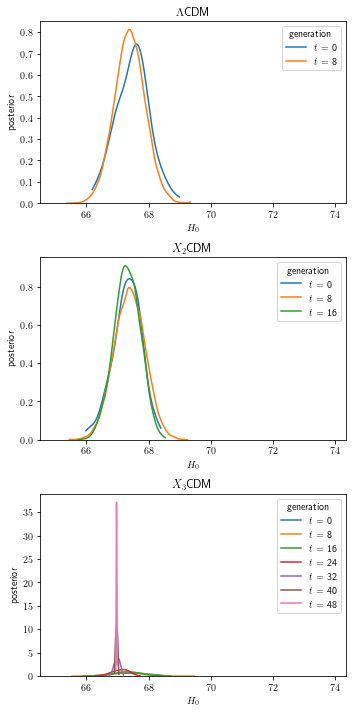

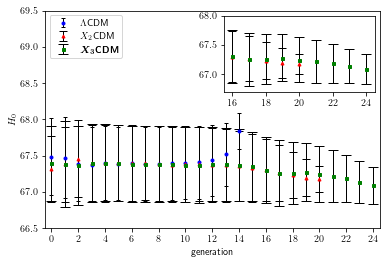

In [21]:
def ax_set(ax, title, xlabel, ylabel, x_min, x_max, \
           legend_title, legend_loc):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(bottom = 0)
    ax.legend(title = legend_title, loc = legend_loc)

fig, axes = plt.subplots(3)
fig.set_size_inches((5, 10))
axes = axes.flatten()
for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 8):
        df, w = history.get_distribution(m = m, t = t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(df, w, 'H0', ax = ax, label = f"$t$ = {t}", numx = 200)
ax_set(axes[0], '$\Lambda$CDM', '$H_0$', 'posterior',
       67 - 0.5*5, 73.30 + 1.04, 'generation', 'upper right')
ax_set(axes[1], '$X_2$CDM', '$H_0$', 'posterior',
       67 - 0.5*5, 73.30 + 1.04, 'generation', 'upper right')
ax_set(axes[2], '$X_3$CDM', '$H_0$', 'posterior',
       67 - 0.5*5, 73.30 + 1.04, 'generation', 'upper right')
fig.tight_layout()
plt.show()

# generational H0 plot
fig, ax = plt.subplots()
ix = inset_axes(ax, width = '45%', height = '35%', \
                loc = 'upper right')
clst = ['b', 'r', 'g']
mlst = ['o', '^', 's']
csze = [2, 4, 5]
legends = ['$\Lambda$CDM', r'$X_2$CDM', r'\textbf{{{\boldmath$X_3$}CDM}']
for k in cred_int:
    i = list(cred_int.keys()).index(k)
    n_gen = len(cred_int[k]['H0'])
    t = np.arange(0, n_gen)
    l = cred_int[k]['H0']
    sigl = cred_int[k]['sigH0']
    ax.errorbar(t, l, yerr = sigl,
                fmt = clst[i] + mlst[i], 
                markersize = 3, ecolor = 'k',
                elinewidth = 1, capsize = csze[i],
                label = legends[i])
    ix.errorbar(t, l, yerr = sigl,
                fmt = clst[i] + mlst[i], 
                markersize = 3, ecolor = 'k',
                elinewidth = 1, capsize = csze[i])
ax.legend(loc = 'upper left', prop = {'size': 9.5})
ax.set_xlabel('generation')
ax.set_ylabel(r'$H_0$')
ax.set_xlim(-0.5, 25 - 0.5)
ax.set_xticks(np.arange(0, 25, 2))
ax.set_ylim(66.5, 69.5)
ix.xaxis.tick_bottom()
ix.set_xlim(16 - 0.5, 25 - 0.5)
ix.set_ylim(66.7, 68.0)
ix.set_xticks(np.arange(16, 25, 2))
ix.xaxis.set_tick_params(labelsize = 10)
ix.yaxis.set_tick_params(labelsize = 10)
plt.show()

Now, we obtain the parameter estimates per generation for the matter fraction. We do so for the $X$CDM model by defining a function that converts from $\Omega_{m0}h^2$ to $\Omega_{m0}$.

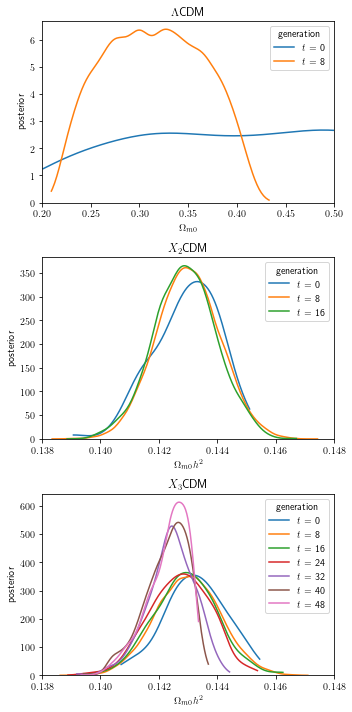

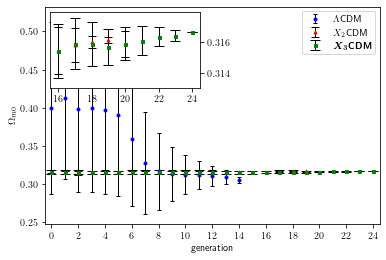

In [22]:
# posterior shape evolution
fig, axes = plt.subplots(3)
fig.set_size_inches((5, 10))
axes = axes.flatten()
for m, ax in enumerate(axes):
    if m == 0: # LCDM
        for t in range(0, history.n_populations, 8):
            df, w = history.get_distribution(m = m, t = t)
            if len(w) > 0:  # Particles in a model might die out
                plot_kde_1d(df, w, 'om0', ax = ax, \
                            label = f"$t$ = {t}", numx = 200)
    if m == 1 or m == 2: # X23CDM
        for t in range(0, history.n_populations, 8):
            df, w = history.get_distribution(m = m, t = t)
            if len(w) > 0 and (m == 1 or m == 2):  # Particles in a model might die out
                plot_kde_1d(df, w, 'om0h2', ax = ax, label = f"$t$ = {t}", numx = 200)
ax_set(axes[0], '$\Lambda$CDM', '$\Omega_{m0}$', 'posterior',
       0.2, 0.5, 'generation', 'upper right')
ax_set(axes[1], '$X_2$CDM', '$\Omega_{m0} h^2$', 'posterior',
       0.138, 0.148, 'generation', 'upper right')
ax_set(axes[2], '$X_3$CDM', '$\Omega_{m0} h^2$', 'posterior',
       0.138, 0.148, 'generation', 'upper right')
fig.tight_layout()
plt.show()

# generational om0 plot
fig, ax = plt.subplots()
ix = inset_axes(ax, width = '45%', height = '35%', \
                loc = 'upper left')
clst = ['b', 'r', 'g']
mlst = ['o', '^', 's']
csze = [2, 4, 5]
legends = ['$\Lambda$CDM', '$X_2$CDM', r'\textbf{{{\boldmath$X_3$}CDM}']
for k in cred_int:
    i = list(cred_int.keys()).index(k)
    if i == 0: # LambdaCDM
        n_gen = len(cred_int[k]['om0'])
        t = np.arange(0, n_gen)
        l = cred_int[k]['om0']
        sigl = cred_int[k]['sigom0']
        ax.errorbar(t, l, yerr = sigl, \
                    fmt = clst[i] + mlst[i], \
                    markersize = 3, ecolor = 'k', \
                    elinewidth = 1, capsize = csze[i], \
                    label = legends[i])
        ix.errorbar(t, l, yerr = sigl, \
                    fmt = clst[i] + mlst[i], \
                    markersize = 3, ecolor = 'k', \
                    elinewidth = 1, capsize = csze[i])
    if i == 1 or i == 2: # X23CDM
        n_gen = len(cred_int[k]['om0h2'])
        t = np.arange(0, n_gen)
        om0h2 = np.array(cred_int[k]['om0h2'])
        sigom0h2 = np.array(cred_int[k]['sigom0h2'])
        H0 = np.array(cred_int[k]['H0'])
        sigH0 = np.array(cred_int[k]['sigH0'])
        om0, sigom0 = Om0(H0, sigH0, om0h2, sigom0h2)
        ax.errorbar(t, om0, yerr = sigom0, \
                    fmt = clst[i] + mlst[i], \
                    markersize = 3, ecolor = 'k', \
                    elinewidth = 1, capsize = csze[i], \
                    label = legends[i])
        ix.errorbar(t, om0, yerr = sigom0, \
                    fmt = clst[i] + mlst[i], \
                    markersize = 3, ecolor = 'k', \
                    elinewidth = 1, capsize = csze[i])
ax.legend(loc = 'upper right', prop = {'size': 9.5})
ax.set_xlabel('generation')
ax.set_ylabel(r'$\Omega_{m0}$')
ax.set_xticks(np.arange(0, 25, 2))
ax.set_xlim(-0.5, 25 - 0.5)
ix.xaxis.tick_bottom()
ix.yaxis.tick_right()
ix.set_xlim(16 - 0.5, 25 - 0.5)
ix.set_ylim(0.313, 0.318)
ix.set_yticks([0.314, 0.316])
ix.set_xticks(np.arange(16, 25, 2))
ix.xaxis.set_tick_params(labelsize = 10)
ix.yaxis.set_tick_params(labelsize = 10)
plt.show()

We plot the best fit curves (determined by the models' last generation) together with the data set below.

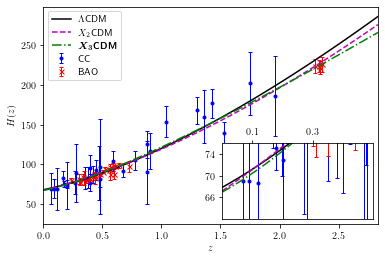

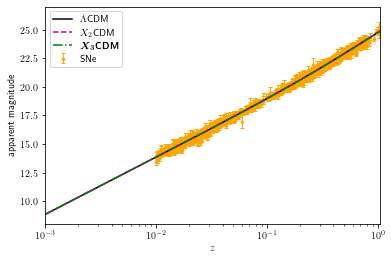

In [23]:
# LambdaCDM best fit
zbf = np.linspace(1e-5, max(z_cc_bao_pp)*6/5, 100)
Hzlcdmbf = last_pop['LCDM']['H0']*\
Ez_qd(zbf, last_pop['LCDM']['om0'], f1 = 1, f2 = 1, zm = max(z_cc_bao_pp))
mzlcdmbf = [mz_qd(z, last_pop['LCDM']['H0'], \
                  last_pop['LCDM']['om0'], f1 = 1, f2 = 1, \
                  zm = max(z_cc_bao_pp), M = -last_pop['LCDM']['M']) for z in zbf]

# X2CDM best fit
h2x2cdmbf = (last_pop['X2CDM']['H0']/100)**2
om0x2cdmbf = last_pop['X2CDM']['om0h2']/h2x2cdmbf
Hzx2cdmbf = last_pop['X2CDM']['H0']*\
Ez_qd(zbf, om0x2cdmbf, f1 = last_pop['X2CDM']['x1'], \
      f2 = last_pop['X2CDM']['x2'], zm = max(z_cc_bao_pp))
mzx2cdmbf = [mz_qd(z, last_pop['X2CDM']['H0'], \
                   om0x2cdmbf, f1 = last_pop['X2CDM']['x1'], \
                   f2 = last_pop['X2CDM']['x2'], \
                   zm = max(z_cc_bao_pp), M = -last_pop['X2CDM']['M']) for z in zbf]

# X3CDM best fit
h2x3cdmbf = (last_pop['X3CDM']['H0']/100)**2
om0x3cdmbf = last_pop['X3CDM']['om0h2']/h2x3cdmbf
Hzx3cdmbf = last_pop['X3CDM']['H0']*\
Ez_cb(zbf, om0x3cdmbf, f1 = last_pop['X3CDM']['x1'], \
      f2 = last_pop['X3CDM']['x2'], f3 = last_pop['X3CDM']['x3'], \
      zm = max(z_cc_bao_pp))
mzx3cdmbf = [mz_cb(z, last_pop['X3CDM']['H0'], \
                   om0x3cdmbf, f1 = last_pop['X3CDM']['x1'], \
                   f2 = last_pop['X3CDM']['x2'], \
                   f3 = last_pop['X3CDM']['x3'], \
                   zm = max(z_cc_bao_pp), M = -last_pop['X3CDM']['M']) for z in zbf]

fig, ax = plt.subplots()
ix = inset_axes(ax, width = '45%', height = '35%', \
                loc = 'lower right')
ax.plot(zbf, Hzlcdmbf, 'k-', label = '$\Lambda$CDM')
ax.plot(zbf, Hzx2cdmbf, 'm--', label = '$X_2$CDM')
ax.plot(zbf, Hzx3cdmbf, 'g-.', label = r'\textbf{{{\boldmath$X_3$}CDM}')
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, fmt = 'bo', ecolor = 'b', \
            markersize = 3, elinewidth = 1, capsize = 2, label = 'CC', zorder = 0)
ax.errorbar(z_bao, Hz_bao, yerr = sigHz_bao, fmt = 'rx', ecolor = 'red', \
            markersize = 5, elinewidth = 1, capsize = 2, label = 'BAO', zorder = 0)
ix.plot(zbf, Hzlcdmbf, 'k-')
ix.plot(zbf, Hzx2cdmbf, 'm--')
ix.plot(zbf, Hzx3cdmbf, 'g-.')
ix.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, fmt = 'bo', ecolor = 'b', \
            markersize = 3, elinewidth = 1, capsize = 2, zorder = 0)
ix.errorbar(z_bao, Hz_bao, yerr = sigHz_bao, fmt = 'rx', ecolor = 'red', \
            markersize = 5, elinewidth = 1, capsize = 2, zorder = 0)

ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
ax.set_xlim(0, max(z_cc_bao_pp)*6/5)
ax.legend(loc = 'upper left', prop = {'size': 9.5})
ix.xaxis.tick_top()
ix.set_xlim(0.00, 0.5)
ix.set_xticks([0.1, 0.3])
ix.set_ylim(62, 76)
ix.set_yticks([66, 70, 74])
ix.xaxis.set_tick_params(labelsize = 10)
ix.yaxis.set_tick_params(labelsize = 10)
plt.show()

# apparent magnitudes
fig, ax = plt.subplots()
ax.plot(zbf, mzlcdmbf, 'k-', label = '$\Lambda$CDM')
ax.plot(zbf, mzx2cdmbf, 'm--', label = '$X_2$CDM')
ax.plot(zbf, mzx3cdmbf, 'g-.', label = r'\textbf{{{\boldmath$X_3$}CDM}')
ax.errorbar(z_pp, mz_pp, yerr = sigmz_pp, \
            fmt = '^', color = 'orange', markersize = 3, \
            ecolor = 'orange', elinewidth = 1, capsize = 2, \
            label = 'SNe', zorder = 0)
ax.set_xscale('log')
ax.set_xlabel('$z$')
ax.set_ylabel('apparent magnitude')
ax.set_xlim(1e-3, np.log(max(zbf)))
ax.set_ylim(8, 27)
ax.legend(loc = 'upper left', prop = {'size': 9.5})
plt.show()